# Connectivity and Shannon entropy analysis for Shin et al. paper
Last edited by Anthony Moussa, 09/29/2024

# Importing libraries

In [34]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import networkx as nx
from scipy import stats
import os
import math
from scipy.stats import binomtest
from scipy.stats import entropy
from scipy.stats import binom

# Connectivity analysis

### compiled data

In [35]:
metadata_df = pd.read_csv(r'C:\Users\antho\Desktop\Finalized datasets\updated_metadata_7.29.24.csv')
metadata_df = metadata_df.loc[~(metadata_df['datasetid'] == 'u1')]
metadata_df.rename(columns = {'celltype':'predicted.celltype'}, inplace = True)

barcodes_df = pd.read_csv(r'C:\Users\antho\Desktop\Finalized datasets\thresholded_barcodes.csv')
helpers_df = pd.read_csv(r'C:\Users\antho\Desktop\Finalized datasets\thresholded_helpers.csv')
barcodes_df['datasetid'] = barcodes_df['CBC'].apply(lambda x: x[0:2])
helpers_df['datasetid'] = helpers_df['CBC'].apply(lambda x: x[0:2])

metadata_df.loc[metadata_df['predicted.celltype'] == 'In', 'predicted.celltype'] = 'Interneurons'


In [3]:
metadata_df

,Unnamed: 0,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,datasetid,virus,modality,age,cellbarcode,thresholded,nCount_SCT,nFeature_SCT,SCT_snn_res.1,seurat_clusters,predicted.celltype,umap_1,umap_2
0,s1_AAAAAACGATGCAAAC,SeuratProject,14442,4765,4.171814,s1,sadb19,cell,gw21,s1_AAAAAACGATGCAAAC,y,4166,2230,6,6,Interneurons,1.419742,-9.583785
1,s1_AAAAAATGAGATAGTT,SeuratProject,2028,1260,4.465710,s1,sadb19,cell,gw21,s1_AAAAAATGAGATAGTT,y,3846,1283,0,0,L2/3,-3.215061,1.740603
2,s1_AAAAAGTAAGAAAGTA,SeuratProject,5206,2197,4.869266,s1,sadb19,cell,gw21,s1_AAAAAGTAAGAAAGTA,y,4674,2178,7,7,Progenitors,6.027566,-6.358721
3,s1_AAAAAGTGAGAGACGC,SeuratProject,3256,1692,3.584229,s1,sadb19,cell,gw21,s1_AAAAAGTGAGAGACGC,y,3717,1676,1,1,L2/3,-1.515306,-1.943823
4,s1_AAACAGTGCCGTAACG,SeuratProject,5351,2501,4.223881,s1,sadb19,cell,gw21,s1_AAACAGTGCCGTAACG,y,4773,2479,1,1,L2/3,-3.016111,-0.833228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17338,n2_CCTTAGATAACTCATA,SeuratProject,405,304,0.193798,n2,cvs,nuc,gw21,n2_CCTTAGATAACTCATA,y,407,283,8,8,L2/3,-6.889194,-0.888443
17339,n2_CCTTATGTAACAAACT,SeuratProject,1257,898,0.044643,n2,cvs,nuc,gw21,n2_CCTTATGTAACAAACT,y,825,729,3,3,L4,-4.661867,3.094223
17340,n2_CCTTATTCACTCAAAC,SeuratProject,1095,786,0.020010,n2,cvs,nuc,gw21,n2_CCTTATTCACTCAAAC,y,793,696,3,3,L4,-3.441950,3.695405
17341,n2_CCTTCCGTATTCATAG,SeuratProject,510,378,0.000000,n2,cvs,nuc,gw21,n2_CCTTCCGTATTCATAG,y,473,350,20,20,L2/3,2.927207,3.161296


In [4]:
barcodes_df

,Unnamed: 0,CBC,barcode,UMI_Count,datasetid
0,21,n1_AGCGACGTACCTAGCA,n1_AATTCAAACCCCTGGCGATGG-GATCAAGCTTCCAACCGTGG-...,4,n1
1,36,n1_AGCACAACAATTCAGG,n1_AATTCAAACCCCTGGCGATGG-GATCAAGCTTCCAACCGTGG-...,7,n1
2,466,n1_CCGGACATACCGCCTT,n1_AATTCAAACCCCTGGCGATGG-GATCACCATGTCCAGTGCCG-...,8,n1
3,594,n1_CAATACGCACTGATTG,n1_AATTCAAACCCCTGGCGATGG-GATCACCGTGCAACCCGGAG-...,25,n1
4,600,n1_ACGAACATACCCCCCT,n1_AATTCAAACCCCTGGCGATGG-GATCACCGTGCAACCCGGAG-...,3,n1
...,...,...,...,...,...
2510475,37523113,s5_AATCATACAGAGCAGG,s5_AATTCTTTTGGTGCGAGCCTG-GATCGGCGATCGTGACACTG-...,3,s5
2510476,37523174,s5_CCTCAGGACCTAAAAT,s5_AATTCTTTTGGTGCGAGCCTG-GATCGGCGATCGTGACACTG-...,3,s5
2510477,37523395,s5_AGCGAGTCCCGGACGG,s5_AATTCTTTTGGTGCGAGCCTG-GATCGGCGATCGTGACACTG-...,3,s5
2510478,37523872,s5_CATCAAGACCTCAACC,s5_AATTCTTTTGGTGCGAGCCTG-GATCGGCGATCGTGACACTG-...,3,s5


In [5]:
helpers_df

,Unnamed: 0,CBC,helper,UMI_Count,datasetid
0,6,n1_CATGATTTAGTTCCAA,n1_helper,3,n1
1,9,n1_CCCGAGACCCGGAATT,n1_helper,3,n1
2,19,n1_ATTTAGGCAAGCAATC,n1_helper,4,n1
3,39,n1_ACGGAATAACTCACGT,n1_helper,3,n1
4,55,n1_ATTACCGTCCTGAGAT,n1_helper,3,n1
...,...,...,...,...,...
2473,40728,s5_AGCTCCTGCAAAATAA,s5_helper,3,s5
2474,40734,s5_CCCCCACGCCAGCCGT,s5_helper,3,s5
2475,40808,s5_AAACAAGCAACTCACT,s5_helper,3,s5
2476,40994,s5_ACTTAGCCAGACCCAG,s5_helper,3,s5


## Preparing barcode data for connectivity analysis


### Function to generate process_barcodes_df

In [36]:
def process_barcodes_df(metadata_df, barcodes_df, helpers_df, barcode_UMI_threshold, helper_UMI_threshold, no_G = False, string_correction = False, celltype_data = False):

        # to convert CBC from string to just barcode
        if string_correction == True:
            barcodes_df['CBC'] = barcodes_df['CBC'].apply(lambda x: x[2:18])
            
        # only consider starters cells that have at least helper_UMI_threshold
        startercells_df = helpers_df.loc[helpers_df['UMI_Count'] >=helper_UMI_threshold].copy()
        
        # to convert CBC from string to just barcode
        if string_correction == True:
            startercells_df['CBC'] = startercells_df['CBC'].apply(lambda x: x[2:18])
        
        # drop barcodes that have less than 3 UMIs, keeping only those with 3 or more
        barcodes_df.drop(barcodes_df[barcodes_df['UMI_Count'] <barcode_UMI_threshold].index, inplace=True)    
        
        # filter for barcodes in cells that have metadata
        barcodes_df = barcodes_df.loc[barcodes_df['CBC'].isin(metadata_df['cellbarcode'])].copy()

        # apply celltype metadata to label barcodes
        if celltype_data == True:
            celltype_dict = dict(zip(metadata_df['cellbarcode'],metadata_df['predicted.celltype']))
            barcodes_df['celltypes'] = barcodes_df['CBC'].apply(lambda x: celltype_dict[x])

        # identifying which barcodes are in >=2 cells
        barcodes_df['duplicate?'] = barcodes_df.duplicated(subset=['barcode'], keep=False)       
        
        #Assign starters
        barcodes_df['helper'] = barcodes_df.loc[:, 'CBC']
        startercells=startercells_df['CBC']
        
        barcodes_df.loc[barcodes_df['CBC'].isin(startercells), 'helper'] = 'starter'
    
        ## keeping helper UMI count affiliated with each cell
        helper_umi_dict = dict(zip(helpers_df['CBC'],helpers_df['UMI_Count']))
    
        barcodes_df['helper_UMI_count'] = barcodes_df['CBC'].apply(lambda x: helper_umi_dict[x] if x in helper_umi_dict.keys() else 0)

        if no_G == False:
            barcodes_df.loc[~barcodes_df['CBC'].isin(startercells), 'helper'] = 'nonstarter'

    # so that all cells in helper only datasets are labeled as starters
        elif no_G == True:
            barcodes_df.loc[~barcodes_df['CBC'].isin(startercells), 'helper'] = 'starter'
    
        # determining and labeling starter and single starter-barcodes:
        starter_barcodes_df = barcodes_df.loc[barcodes_df['helper'] == 'starter'].copy()

        starter_barcodes_list = list(starter_barcodes_df.drop_duplicates('barcode')['barcode'])
        barcodes_df.loc[(barcodes_df['barcode'].isin(starter_barcodes_list)),'starter_barcode'] = 'y'
        barcodes_df.loc[~(barcodes_df['barcode'].isin(starter_barcodes_list)),'starter_barcode'] = 'n'        
        
        starter_barcodes_df_counts = starter_barcodes_df.groupby('barcode').count()['CBC'].reset_index()
        single_starter_barcodes = list(starter_barcodes_df_counts.loc[starter_barcodes_df_counts['CBC'] == 1]['barcode'])
    
        # label single starter barcodes (subset of starter barcodes)
        barcodes_df.loc[barcodes_df['barcode'].isin(single_starter_barcodes),'single_starter_barcode'] = 'y'
        barcodes_df.loc[~(barcodes_df['barcode'].isin(single_starter_barcodes)),'single_starter_barcode'] = 'n'

        # determining and labeling nonstarter barcodes:
        nonstarter_barcodes_df = barcodes_df.loc[barcodes_df['helper'] == 'nonstarter']
        nonstarter_barcodes_list = list(nonstarter_barcodes_df.drop_duplicates('barcode')['barcode'])
        barcodes_df.loc[(barcodes_df['barcode'].isin(nonstarter_barcodes_list)),'non_starter_barcode'] = 'y'
        barcodes_df.loc[~(barcodes_df['barcode'].isin(nonstarter_barcodes_list)),'non_starter_barcode'] = 'n'
    
        barcodes_df.loc[(barcodes_df['non_starter_barcode'] == 'y') & (barcodes_df['starter_barcode'] == 'y'),'starter/nonstarter barcode'] = 'both'
        barcodes_df.loc[(barcodes_df['non_starter_barcode'] == 'y') & (barcodes_df['starter_barcode'] == 'n'),'starter/nonstarter barcode'] = 'nonstarter_only'
        barcodes_df.loc[(barcodes_df['non_starter_barcode'] == 'n') & (barcodes_df['starter_barcode'] == 'y'),'starter/nonstarter barcode'] = 'starter_only'
        barcodes_df.loc[(barcodes_df['non_starter_barcode'] == 'n') & (barcodes_df['starter_barcode'] == 'n'),'starter/nonstarter barcode'] = 'error'
    
        return barcodes_df

### generating process_barcodes_df

In [37]:
processed_barcodes_df = process_barcodes_df(metadata_df,barcodes_df,helpers_df, barcode_UMI_threshold = 3, helper_UMI_threshold =3, celltype_data = True)

In [11]:
processed_barcodes_df

,Unnamed: 0,CBC,barcode,UMI_Count,datasetid,celltypes,duplicate?,helper,helper_UMI_count,starter_barcode,single_starter_barcode,non_starter_barcode,starter/nonstarter barcode
23,3198,n1_CCTGACTCCCCTCCGA,n1_AATTCAAACCCCTGGCGATGG-GATCCATGTCGATTGCCCGG-...,5,n1,Astrocytes,False,nonstarter,0,n,n,y,nonstarter_only
83,8898,n1_AACTATCTATTAACTC,n1_AATTCAAACCCCTGGCGATGG-GATCTCTCGGAGCCGGGTAG-...,7,n1,L5/6/SP,False,nonstarter,0,n,n,y,nonstarter_only
135,18446,n1_CAAGATTAAGAGCCTA,n1_AATTCAACAGCCCTCTACACG-GATCGGTGAGACTACGGCTG-...,3,n1,RG,False,starter,3,y,y,n,starter_only
195,22031,n1_CCAACCGCAACCACTA,n1_AATTCAACCTCAGCGACTTCG-GATCACGCCCGGAAGTCGGG-...,4,n1,L2/3,True,nonstarter,0,y,y,y,both
231,22546,n1_CCGCCCGCAACTAAAT,n1_AATTCAACCTCAGCGACTTCG-GATCACGCCCGGAAGTCGGG-...,4,n1,Progenitors,True,nonstarter,0,y,y,y,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510437,37521520,s5_AAATATCTAAGCACGA,s5_AATTCTTTTGGTGCGAGCCTG-GATCGGCGATCGTGACACTG-...,3,s5,Astrocytes,True,nonstarter,0,y,n,y,both
2510445,37521679,s5_CCGCCCGGACTACCTC,s5_AATTCTTTTGGTGCGAGCCTG-GATCGGCGATCGTGACACTG-...,4,s5,L2/3,True,nonstarter,0,y,n,y,both
2510456,37521965,s5_AGCAACGAACCTCAAC,s5_AATTCTTTTGGTGCGAGCCTG-GATCGGCGATCGTGACACTG-...,3,s5,L2/3,True,nonstarter,0,y,n,y,both
2510474,37522975,s5_AGTACCCTCCAGATCA,s5_AATTCTTTTGGTGCGAGCCTG-GATCGGCGATCGTGACACTG-...,3,s5,Astrocytes,True,nonstarter,0,y,n,y,both


## Calculating relevant barcode metrics and distributions

In [38]:
# determining distribution of number of starter cells across all barcode networks post UMI thresholding at 3
processed_barcodes_df.loc[processed_barcodes_df['helper'] == 'nonstarter']
starter_df = processed_barcodes_df.loc[processed_barcodes_df['helper'] == 'starter']
starter_df.groupby('barcode').count().reset_index

df2 = processed_barcodes_df.groupby(['barcode','helper']).count()['CBC'].reset_index()
# so that starters appear first in alphabetical order
df2 = df2.sort_values('helper', ascending = False).drop_duplicates('barcode', keep = 'first')

df2.loc[df2['helper'] == 'nonstarter', 'CBC'] = 0
df2.loc[df2['helper'] == 'nonstarter', 'helper'] = 'starter'
df2.loc[df2['helper'] == 'starter', 'helper'] = 'starter'

df2.sort_values('CBC',ascending = False).rename(columns = {'CBC':'number of starter cells with barcode'})

,barcode,helper,number of starter cells with barcode
15285,s5_AATTCTTGCTCGCAAGGGATG-GATCCACTCAGCTGTCGTAG-...,starter,159
12423,s3_AATTCTGCGCTTAACCCAGGG-GATCGACCGCATCCTCTATG-...,starter,145
12391,s3_AATTCTCGCGCTGAACAGGCG-GATCTTGCGGGTGGTTGCTG-...,starter,129
11977,s3_AATTCCCATGAAGGGTCAAGG-GATCAGTCGCAGTGCCCGGG-...,starter,127
13073,s4_AATTCCGCTTCCGATGCCGCG-GATCCGAAGTTAGGCCGGTG-...,starter,125
...,...,...,...
10056,n2_AATTCCACCTGAAGCTCCATG-GATCTCACCCTTTACGGTCG-...,starter,0
10051,n2_AATTCCACCCCGCAATATGCG-GATCGGGGCTCCCACTTCGG-...,starter,0
2846,c2_AATTCATGGTATGCGATGCGG-GATCAGCTCGGGCGGCAAGG-...,starter,0
7867,c2_AATTCTGTCAGTCCCTGTTGG-GATCGCGCGCGTGAAAATGG-...,starter,0


In [14]:
# determining distribution of number of cells per barcode after removing all barcodes with either no or more than 1 starter
processed_barcodes_df.loc[processed_barcodes_df['single_starter_barcode'] == 'y'].groupby('barcode').count()['helper'].reset_index().rename(columns = {'helper':'number of cells with barcode'}).sort_values('number of cells with barcode',ascending = False)

,barcode,number of cells with barcode
1399,c2_AATTCGTAGTATCGTAGGCGG-GATCTCCTCTGTGCCCGAAG-...,84
469,c2_AATTCACTGGTCGCTCGCCGG-GATCAAGGTGCGCCACCAGG-...,72
1333,c2_AATTCGGGCCCGAACACATTG-GATCTGGGTGCATGGTCGAG-...,67
812,c2_AATTCCCGAACCCAGAGGGGG-GATCCACGCGTAGTAGTAGG-...,67
557,c2_AATTCAGGAGAACGCGAGATG-GATCCACGACGGGATGATAG-...,60
...,...,...
21,c1_AATTCACCGAGAAGATTCCGG-GATCGTAAGGCCCCACCTGG-...,1
22,c1_AATTCACCTCCCTTCAATCCG-GATCCCTCGCAGAATCTCTG-...,1
925,c2_AATTCCGCCGTCGATCTATTG-GATCCCATGTGGCCACAGTG-...,1
928,c2_AATTCCGCCGTTTCCGACTTG-GATCGGGTAGGTCAGCAATG-...,1


In [15]:
# determine number of unique barcodes overall
processed_barcodes_df['barcode'].nunique()

12036

In [16]:
# determine number of barcodes found in starter cells
processed_barcodes_df.loc[(processed_barcodes_df['helper'] == 'starter')]['barcode'].nunique()

5047

In [17]:
# determine number of barcodes found in single starter cells
processed_barcodes_df.loc[(processed_barcodes_df['single_starter_barcode'] == 'n') & (processed_barcodes_df['helper'] == 'starter')]['barcode'].nunique()

2285

In [18]:
# determine number of barcodes found in single starter cells
processed_barcodes_df.loc[(processed_barcodes_df['single_starter_barcode'] == 'y')]['barcode'].nunique()

2762

In [19]:
# determine number of barcodes found in single starter cells and at least one non-starter cell
processed_barcodes_df.loc[(processed_barcodes_df['single_starter_barcode'] == 'y') & (processed_barcodes_df['starter/nonstarter barcode'] == 'both')]['barcode'].nunique()

1102

## Determine single starter directed networks

In [39]:
df = processed_barcodes_df.loc[(processed_barcodes_df['single_starter_barcode'] == 'y') & (processed_barcodes_df['starter/nonstarter barcode'] == 'both')]
cell_type_dict = dict(zip(df['CBC'],df['celltypes']))

starter_df = df.loc[df['helper'] == 'starter'].groupby(['datasetid','CBC'])['barcode'].apply(set).reset_index()
starter_dict = dict(zip(starter_df['CBC'],starter_df['barcode']))

nonstarter_df = df.loc[df['helper'] == 'nonstarter'].groupby(['CBC'])['barcode'].apply(set).reset_index()
nonstarter_dict = dict(zip(nonstarter_df['CBC'],nonstarter_df['barcode']))

for starter in starter_dict.keys():
    
    matching_cells = []
    starter_barcode_set = starter_dict[starter]
    
    for nonstarter in nonstarter_dict.keys():
        nonstarter_barcode_set = nonstarter_dict[nonstarter]
        
        if len(starter_barcode_set.intersection(nonstarter_barcode_set))>=1:
            matching_cells.append(nonstarter)
    # print(matching_cells) 
    starter_df.loc[starter_df['CBC'] == starter, 'matching_cells'] = str(matching_cells)

starter_df['matching_cells'] = starter_df['matching_cells'].apply(ast.literal_eval)
starter_df.rename(columns = {'CBC':'starter CBC', 'barcode':'starter barcodes', 'matching_cells':'non-starter CBC'}, inplace = True)

starter_df['starter cell_type'] = starter_df['starter CBC'].apply(lambda x: cell_type_dict[x])
conn_0_compiling = starter_df[['datasetid','starter cell_type','starter CBC','non-starter CBC']]
conn_0_compiling['number of non-starters associated'] = conn_0_compiling['non-starter CBC'].apply(lambda x: len(x))
conn_0_compiling['number of cells in single-starter network'] = conn_0_compiling['non-starter CBC'].apply(lambda x: len(x) +1)

conn_1_compiling = starter_df.explode('non-starter CBC')
conn_1_compiling['non-starter cell_type'] = conn_1_compiling['non-starter CBC'].apply(lambda x: cell_type_dict[x])

conn_1_compiling = conn_1_compiling[['datasetid','starter cell_type','starter CBC','non-starter cell_type','non-starter CBC']]
conn_1_compiling['conn_type'] = conn_1_compiling['non-starter cell_type'] +'-'+ conn_1_compiling['starter cell_type'] 
conn_1_compiling['connection'] = conn_1_compiling.apply(lambda x: (x['non-starter CBC'], x['starter CBC'], {'w':1}), axis=1)

In [40]:
# aggregated connectivity info by starter cell
conn_0_compiling

,datasetid,starter cell_type,starter CBC,non-starter CBC,number of non-starters associated,number of cells in single-starter network
0,c1,L2/3,c1_AAAAACTGCCAGAACT,"[c1_ATCACAGAACTACCTC, c1_CAAAAGATCACGATCC, c1_...",4,5
1,c1,L2/3,c1_AAAAATACAATCATTA,"[c1_AACGAAGTATACCCTT, c1_AACGCCATCCTACCTG, c1_...",10,11
2,c1,L5/6/SP,c1_AAAACACTCATACACG,"[c1_AAACCACGACAGCCGT, c1_AATCATACAGTAATAT, c1_...",15,16
3,c1,L2/3,c1_AAAGAGTGCCGTCCGT,"[c1_AAACCATTCCATACCT, c1_AAAGACACAACGCAAG, c1_...",5,6
4,c1,L5/6/SP,c1_AAAGCAATACGCAAAT,"[c1_AAAGATCTAAGACCCG, c1_AAAGATGAACTACCTT, c1_...",5,6
...,...,...,...,...,...,...
452,s5,L2/3,s5_CATTAGGGAACTCAAA,"[s5_AAAAAACCATTGACTT, s5_AAAGAATCACCGCCTA, s5_...",11,12
453,s5,L4,s5_CATTCATTATCGAGAG,[s5_ACCGCAACACCTAGAC],1,2
454,s5,L2/3,s5_CCACCCAGAATCAAAA,"[s5_AAGCACGCACTGAGCG, s5_AGAAAGTCACTGAGCG, s5_...",4,5
455,s5,L2/3,s5_CCGCCATAAAGAATAT,[s5_ACTTAAGTAGCCCACC],1,2


In [22]:
# info for each connection
conn_1_compiling

,datasetid,starter cell_type,starter CBC,non-starter cell_type,non-starter CBC,conn_type,connection
0,c1,L2/3,c1_AAAAACTGCCAGAACT,L4,c1_ATCACAGAACTACCTC,L4-L2/3,"(c1_ATCACAGAACTACCTC, c1_AAAAACTGCCAGAACT, {'w..."
0,c1,L2/3,c1_AAAAACTGCCAGAACT,L4,c1_CAAAAGATCACGATCC,L4-L2/3,"(c1_CAAAAGATCACGATCC, c1_AAAAACTGCCAGAACT, {'w..."
0,c1,L2/3,c1_AAAAACTGCCAGAACT,Interneurons,c1_CCAGCATGAAGTAATC,Interneurons-L2/3,"(c1_CCAGCATGAAGTAATC, c1_AAAAACTGCCAGAACT, {'w..."
0,c1,L2/3,c1_AAAAACTGCCAGAACT,Astrocytes,c1_CCATAAAGAGCCAACG,Astrocytes-L2/3,"(c1_CCATAAAGAGCCAACG, c1_AAAAACTGCCAGAACT, {'w..."
1,c1,L2/3,c1_AAAAATACAATCATTA,L2/3,c1_AACGAAGTATACCCTT,L2/3-L2/3,"(c1_AACGAAGTATACCCTT, c1_AAAAATACAATCATTA, {'w..."
...,...,...,...,...,...,...,...
456,s5,L2/3,s5_CCGGACTTAAAGCCCT,L2/3,s5_CATACAATCAGAAGGC,L2/3-L2/3,"(s5_CATACAATCAGAAGGC, s5_CCGGACTTAAAGCCCT, {'w..."
456,s5,L2/3,s5_CCGGACTTAAAGCCCT,L5/6/SP,s5_CCAAACATCCCGAGAA,L5/6/SP-L2/3,"(s5_CCAAACATCCCGAGAA, s5_CCGGACTTAAAGCCCT, {'w..."
456,s5,L2/3,s5_CCGGACTTAAAGCCCT,L2/3,s5_CCATCACGACGGCCTA,L2/3-L2/3,"(s5_CCATCACGACGGCCTA, s5_CCGGACTTAAAGCCCT, {'w..."
456,s5,L2/3,s5_CCGGACTTAAAGCCCT,L2/3,s5_CCGACAGAAAACATAG,L2/3-L2/3,"(s5_CCGACAGAAAACATAG, s5_CCGGACTTAAAGCCCT, {'w..."


## Graph creation and analysis

### Graph creation functions for automated graph creation

In [23]:
def graph_draw(G, using_barcodes_df):
            
        pos = nx.nx_agraph.graphviz_layout(G, prog='neato', root=None, args='')  

        fig, ax = plt.subplots()
        edge_list = list(G.edges())
        nodes_list = list(G.nodes())

# scale node size by max degree among nodes
        if len(edge_list) >1:
            max_degree = max([x[1] for x in list(G.degree())])
            nodescale = 200

            nodesize = [nodescale*x[1]/max_degree for x in list(G.degree())]

        celltype_dict = dict(zip(using_barcodes_df['CBC'], using_barcodes_df['celltypes']))
    
        keys = ['L4', 'L2/3', 'Interneurons', 'L5/6/SP', 'Astrocytes', 'Progenitors', 'RG', 'OPCs']
        values = ['#D53E4F','#FDAE61', '#5E4FA2', '#882255','#EECC66','#3288BD', '#ABDDA4', '#88CCEE']
        colors_dict = dict(zip(keys, values))
        color_list_nodes = list(map(lambda x: colors_dict[x], list(map(lambda x: celltype_dict[x], nodes_list)))) 

        # draw nodes
        nx.draw_networkx_nodes(G, pos, ax=ax, node_color=color_list_nodes, node_size =nodesize)

        # color edges by cell type of nonstarter neuron
        if len(edge_list) >1:
            edges_colors = list(map(lambda x: colors_dict[x], list(map(lambda x: celltype_dict[x[0]], edge_list))))      
            nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edge_list, width = 1/10, node_size = nodesize, edge_color=edges_colors, arrowsize = 4, arrows=True)

# add degree legend
        size_ranges = [np.array(nodesize).min(), np.median(np.array(nodesize)), np.array(nodesize).max()]
        size_labels = [f'Min: {max_degree/nodescale*size_ranges[0]:.2f}', f'Median: {max_degree/nodescale*size_ranges[1]:.2f}', f'Max: {max_degree/nodescale*size_ranges[2]:.2f}']
        
        for size, label in zip(size_ranges, size_labels):
           ax.scatter([], [], s=size, color='black', alpha=0.6, label=label)
        
        ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper left', title= 'Node degree', bbox_to_anchor=(1.00, 1.5))
    
# add cell type legend
        for celltype, color in colors_dict.items():
           ax.scatter([], [], s=100, color=color, alpha=0.6, label=celltype)

# keep title for degree but plot cell type colors
        ax.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='upper left',title= 'Node degree', bbox_to_anchor=(1.00, 1.0))

        return fig

In [24]:
def graph_plot(conn_1, using_barcodes_df, folder_name, graph_name, download):

    G = nx.DiGraph()
   
    G.add_nodes_from(set(conn_1['non-starter CBC']).union(set(conn_1['starter CBC'])))

    edge_list = []    
    edge_list = list(conn_1['connection'])
    
    G.add_edges_from(edge_list)       
    
#   create folder for saving new graphs
    if download == True:
        newpath = fr'C:\Users\antho\Desktop\{folder_name}' 
        if not os.path.exists(newpath):
            os.makedirs(newpath)
            
    G_plot = G
    fig = graph_draw(G_plot, using_barcodes_df)
    fig.set_size_inches(10,10)
    if download == True:
        # fig.savefig(fr'C:\Users\antho\Desktop\{folder_name}\{graph_name}.svg')
        fig.savefig(fr'C:\Users\antho\Desktop\{folder_name}\{graph_name}.pdf')

### Generating graphs

s3
s2
s4
c2
n2
c1
s1
n1
s5


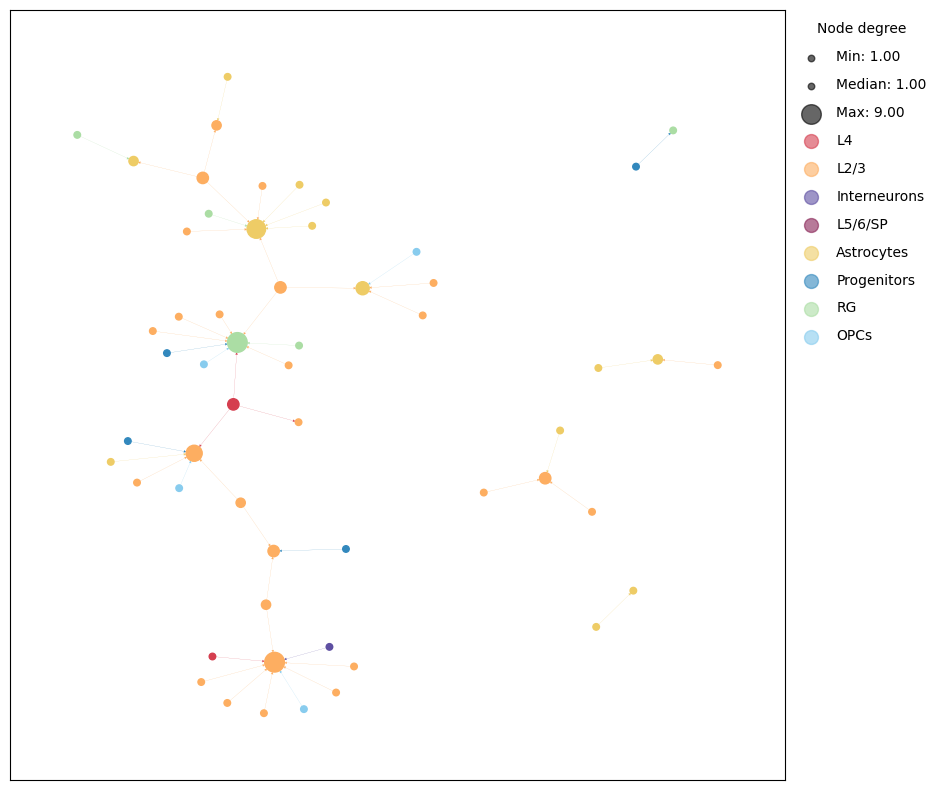

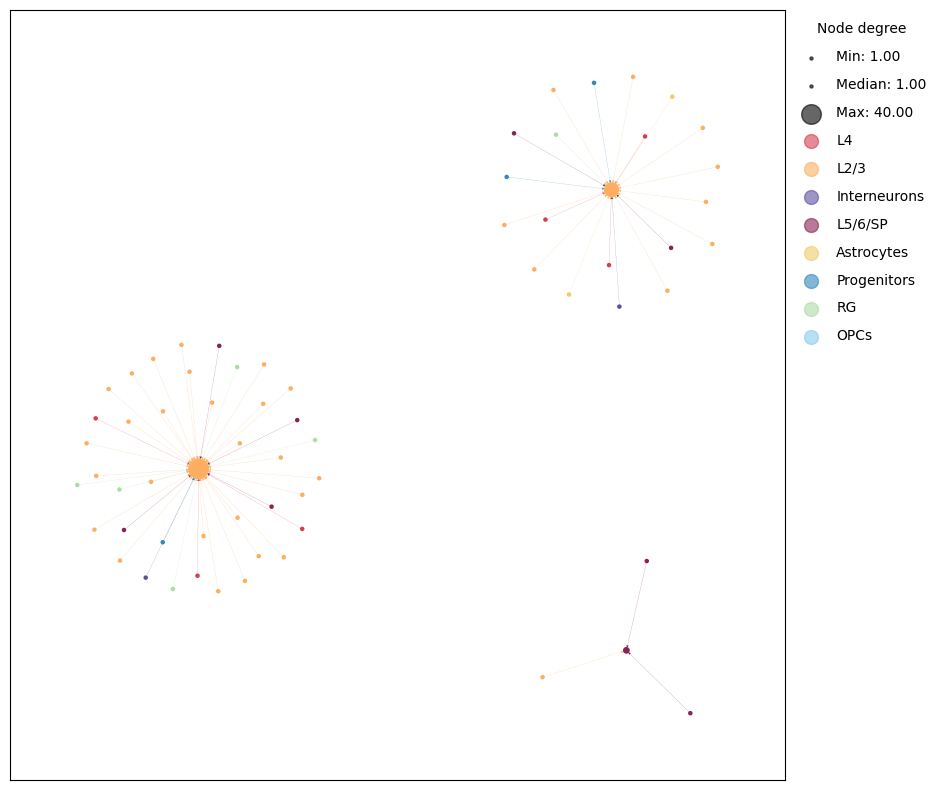

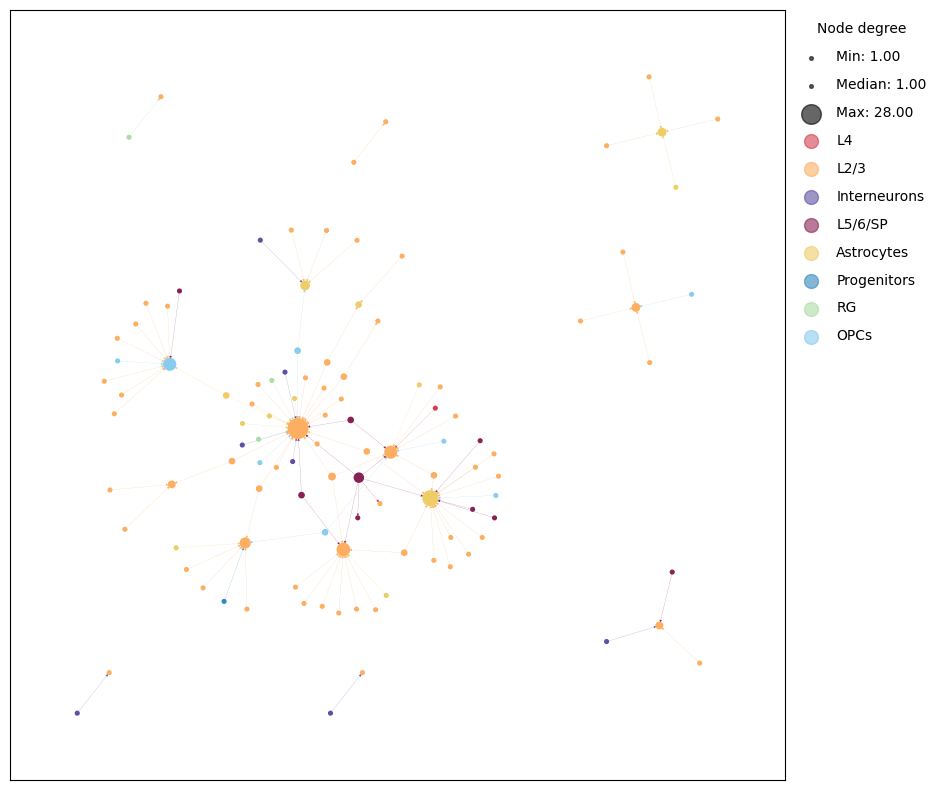

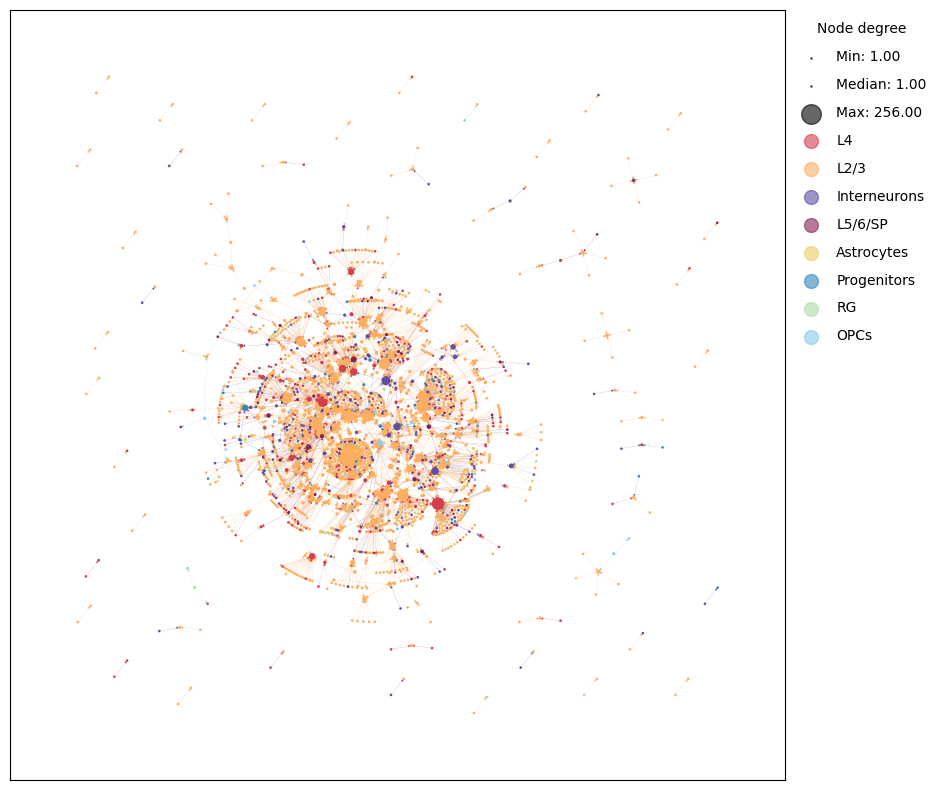

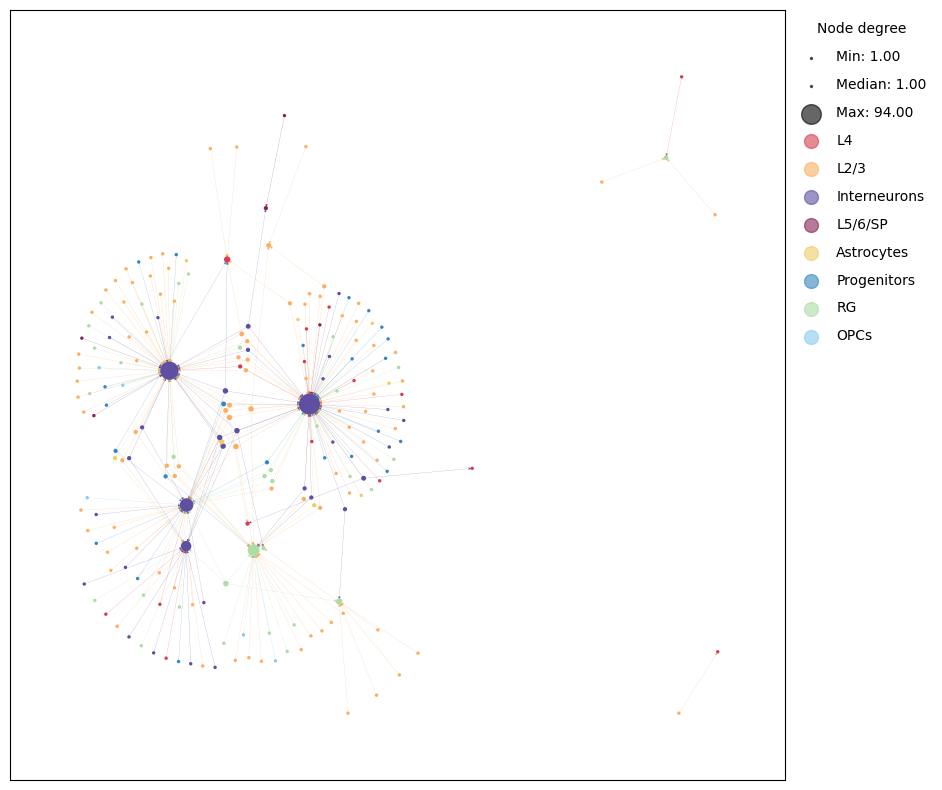

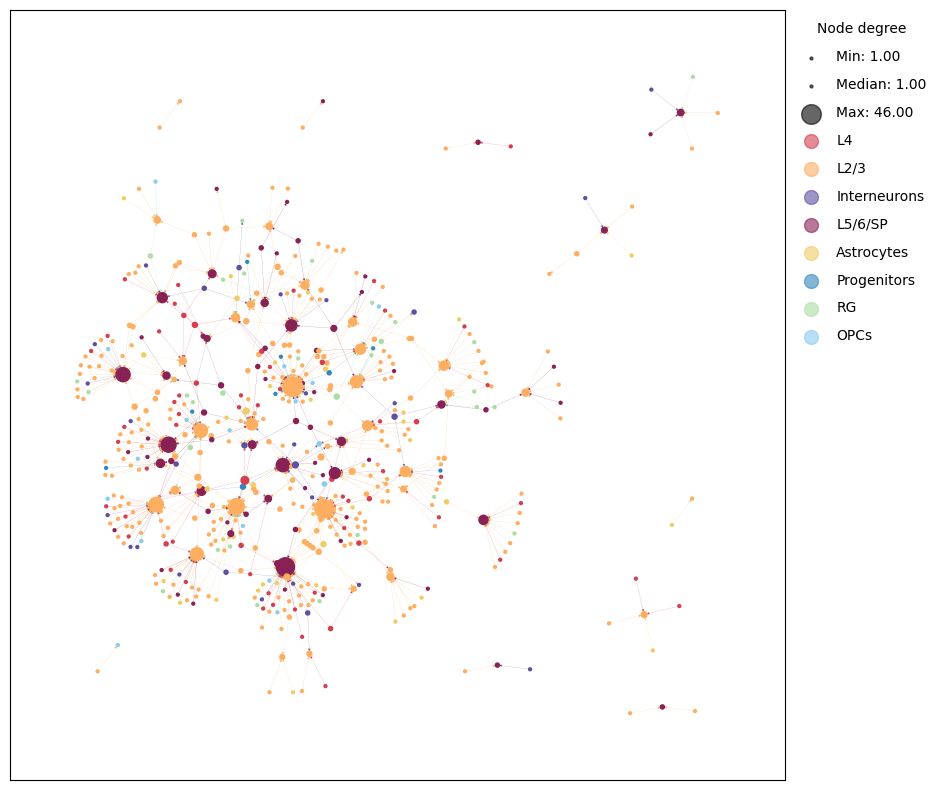

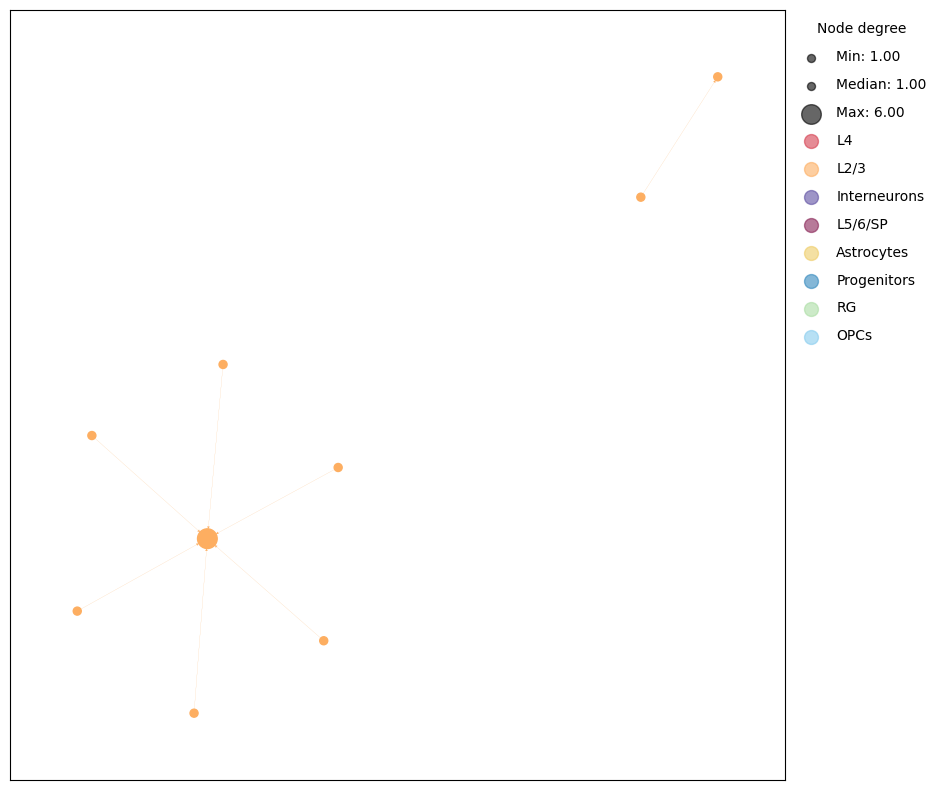

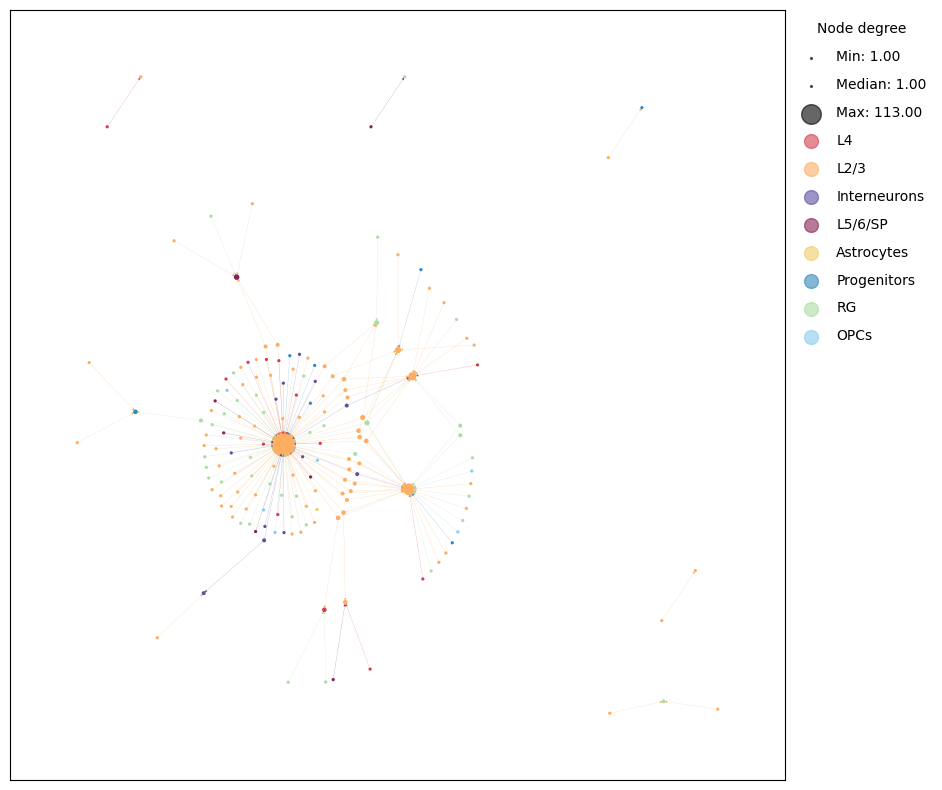

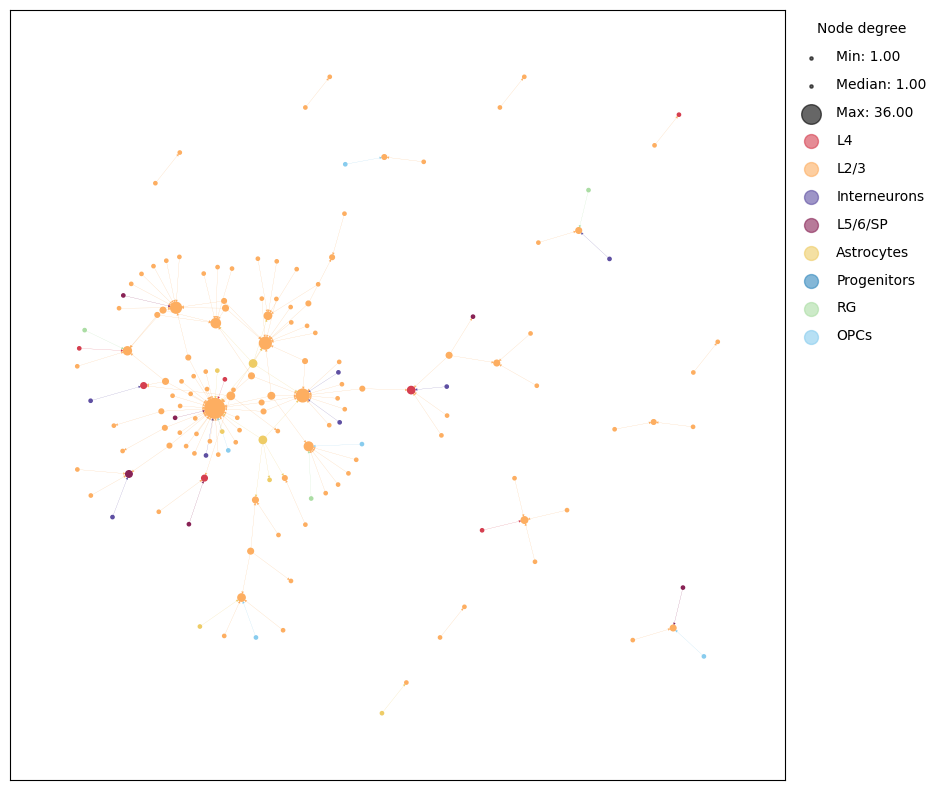

In [165]:
download = False
dataset = list(set(processed_barcodes_df['datasetid']))
folder_name = 'directed graphs with legend'

for datasets in dataset:
    print(datasets)
    datasets = [datasets]
    
    using_barcodes_df = processed_barcodes_df.loc[processed_barcodes_df['datasetid'].isin(datasets)]
    conn_0 = conn_0_compiling.loc[conn_0_compiling['datasetid'].isin(datasets)]
    conn_1 = conn_1_compiling.loc[conn_1_compiling['datasetid'].isin(datasets)]
    
    graph_name = f'directed_{datasets}_single_starter_network'
    graph_plot(conn_1, using_barcodes_df, folder_name = folder_name, graph_name = graph_name, download = download)

### Analyzing graphs

#### number of cells per single-starter network

Text(0.5, 0, 'number of cells in single-starter network')

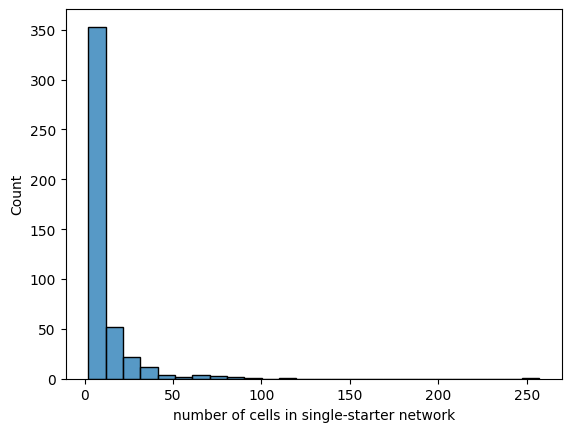

In [30]:
df2 =conn_0_compiling[['starter CBC','number of cells in single-starter network']].sort_values('number of cells in single-starter network',ascending = False)
sns.histplot(df2['number of cells in single-starter network'], binwidth = 10)
plt.xlabel('number of cells in single-starter network')

# plt.savefig(fr'C:\Users\antho\Desktop\pub figures\'number of cells per single-starter network (excluding 1 cell networks).pdf', bbox_inches = 'tight', format = 'pdf')

In [31]:
df2['number of cells in single-starter network'].median()

np.float64(5.0)

#### Determining cell composition of single-starter networks

In [27]:
conn_0_compiling.sort_values('number of cells in single-starter network', ascending = False, inplace = True)
conn_0_compiling['starter network id'] = list(range(1, len(conn_0_compiling)+1))
conn_0_compiling['starter CBC'] = conn_0_compiling['starter CBC'].apply(lambda x: [x])
conn_0_compiling['CBC'] = conn_0_compiling.apply(lambda x: x['starter CBC'] + x['non-starter CBC'], axis=1)
conn_0_compiling

,datasetid,starter cell_type,starter CBC,non-starter CBC,number of non-starters associated,number of cells in single-starter network,starter network id,CBC
143,c2,L2/3,[c2_ACGCCCAGCCCGAACG],"[c2_AAAAACACCCTTATTC, c2_AAACACGGACCTAATC, c2_...",256,257,1,"[c2_ACGCCCAGCCCGAACG, c2_AAAAACACCCTTATTC, c2_..."
358,n1,L2/3,[n1_ACCGATCACATAACGC],"[n1_AAAACCGCATATATAG, n1_AAAACCTTATTCATCC, n1_...",113,114,2,"[n1_ACCGATCACATAACGC, n1_AAAACCGCATATATAG, n1_..."
376,n2,Interneurons,[n2_ACGGACAAACAGCATG],"[n2_AAACAGGTAAACAGAG, n2_AAACAGGTCAAACCGT, n2_...",94,95,3,"[n2_ACGGACAAACAGCATG, n2_AAACAGGTAAACAGAG, n2_..."
212,c2,L4,[c2_ATACCAATCAAGAGCA],"[c2_AAAACCTGACTCAACC, c2_AAACCCTGATGACCTG, c2_...",85,86,4,"[c2_ATACCAATCAAGAGCA, c2_AAAACCTGACTCAACC, c2_..."
172,c2,L2/3,[c2_AGCAAAGTCATTAGCG],"[c2_AAAAATAGCCGTACAG, c2_AAACAAACAATGAAGA, c2_...",80,81,5,"[c2_AGCAAAGTCATTAGCG, c2_AAAAATAGCCGTACAG, c2_..."
...,...,...,...,...,...,...,...,...
429,s5,Astrocytes,[s5_AAGCCCGCAATGAGGT],[s5_ACCAAGAGCCCGATCG],1,2,453,"[s5_AAGCCCGCAATGAGGT, s5_ACCAAGAGCCCGATCG]"
434,s5,L2/3,[s5_ACCCAGCTCCAGCCAA],[s5_ATTGCAGCACAGAGAG],1,2,454,"[s5_ACCCAGCTCCAGCCAA, s5_ATTGCAGCACAGAGAG]"
437,s5,L2/3,[s5_ACCGCCTCACCGATGC],[s5_AGCCACCCAGGTAAGA],1,2,455,"[s5_ACCGCCTCACCGATGC, s5_AGCCACCCAGGTAAGA]"
438,s5,L2/3,[s5_ACGGCATAAGAGATAG],[s5_AGAACATAATATAACT],1,2,456,"[s5_ACGGCATAAGAGATAG, s5_AGAACATAATATAACT]"


In [28]:
df = processed_barcodes_df.loc[(processed_barcodes_df['single_starter_barcode'] == 'y') & (processed_barcodes_df['duplicate?'] == True)]
cell_type_dict = dict(zip(df['CBC'],df['celltypes']))
starter_dict = dict(zip(df['CBC'],df['helper']))

df2 = conn_0_compiling.explode('CBC')[['datasetid','starter network id','number of cells in single-starter network','CBC']]
df2['celltype'] = df2['CBC'].apply(lambda x: cell_type_dict[x])
df2['starter status'] = df2['CBC'].apply(lambda x: starter_dict[x])

starter_dict_updated = {'nonstarter':'non-starter','starter':'starter'}
df2['starter status'] = df2['starter status'].apply(lambda x: starter_dict_updated[x])
df2

,datasetid,starter network id,number of cells in single-starter network,CBC,celltype,starter status
143,c2,1,257,c2_ACGCCCAGCCCGAACG,L2/3,starter
143,c2,1,257,c2_AAAAACACCCTTATTC,L2/3,non-starter
143,c2,1,257,c2_AAACACGGACCTAATC,L2/3,non-starter
143,c2,1,257,c2_AAACATACATTAAATT,L2/3,non-starter
143,c2,1,257,c2_AAACATCGAATGAACA,Astrocytes,non-starter
...,...,...,...,...,...,...
437,s5,455,2,s5_AGCCACCCAGGTAAGA,L2/3,non-starter
438,s5,456,2,s5_ACGGCATAAGAGATAG,L2/3,starter
438,s5,456,2,s5_AGAACATAATATAACT,L2/3,non-starter
7,c1,457,2,c1_AAGTAAAAAGTTCATG,L5/6/SP,starter


In [11]:
df2.to_csv(r'C:\Users\antho\Desktop\'composition of cells per single-starter network (excluding 1 cell networks).csv')

# Generating connectivity matrix

## importing datasets for production of null matrix

### low helper no G data

In [42]:
metadata_df =pd.read_csv(r'C:\Users\antho\Desktop\Finalized datasets\no_g_metadata.csv')
metadata_df = metadata_df.loc[metadata_df['datasetid'] == 'cl']

helpers_df = pd.read_table(r'C:\Users\antho\Desktop\cvs_low\helperindex.tsv')
barcodes_df = pd.read_table(r'C:\Users\antho\Desktop\cvs_low\completecounts.tsv')
metadata_df['CBC'] = metadata_df['cellbarcode']
metadata_df.rename(columns = {'celltype':'predicted.celltype'}, inplace = True)

metadata_df.loc[metadata_df['predicted.celltype'] == 'In', 'predicted.celltype'] = 'Interneurons'

barcodes_df['CBC'] = barcodes_df['CBC'].apply(lambda x: x[2:18])
helpers_df['CBC'] = helpers_df['CBC'].apply(lambda x: x[2:18])


barcodes_df['datasetid'] = 'cl'
helpers_df['datasetid'] = 'cl'
# metadata_df['datasetid'] = 'cl'

barcodes_df['barcode'] = barcodes_df['datasetid'] + '_' + barcodes_df['barcode']
barcodes_df['CBC'] = barcodes_df['datasetid'] + '_' + barcodes_df['CBC']
# metadata_df['CBC'] = metadata_df['datasetid'] + '_' + metadata_df['CBC']
helpers_df['CBC'] = helpers_df['datasetid'] + '_' + helpers_df['CBC']
metadata_df['cellbarcode'] = metadata_df['CBC']
helpers_df['helper'] = helpers_df['datasetid'] + '_' + helpers_df['helper']

In [43]:
barcodes_df_cl = barcodes_df
metadata_df_cl = metadata_df
helpers_df_cl = helpers_df

In [44]:
metadata_df_cl_cellcounts = metadata_df_cl.groupby('predicted.celltype').count()['cellbarcode'].reset_index()
metadata_df_cl_cellcounts['proportion'] = metadata_df_cl_cellcounts['cellbarcode']/metadata_df_cl_cellcounts['cellbarcode'].sum()
metadata_df_cl_cellcounts

,predicted.celltype,cellbarcode,proportion
0,Astrocytes,20,0.025284
1,Interneurons,38,0.048040
2,L2/3,550,0.695322
3,L4,109,0.137800
4,L5/6/SP,30,0.037927
5,Progenitors,31,0.039191
6,RG,13,0.016435


In [45]:
processed_barcodes_df_cl = process_barcodes_df(metadata_df_cl,barcodes_df_cl,helpers_df_cl, barcode_UMI_threshold = 3, helper_UMI_threshold =0, celltype_data = True, no_G = True)

In [46]:
processed_barcodes_df_cl_cell_counts = processed_barcodes_df_cl.drop_duplicates('CBC').groupby('celltypes').count()['CBC'].reset_index()
processed_barcodes_df_cl_cell_counts['proportion'] = processed_barcodes_df_cl_cell_counts['CBC']/processed_barcodes_df_cl_cell_counts['CBC'].sum()
processed_barcodes_df_cl_cell_counts

,celltypes,CBC,proportion
0,Astrocytes,10,0.020
1,Interneurons,20,0.040
2,L2/3,372,0.744
3,L4,49,0.098
4,L5/6/SP,14,0.028
5,Progenitors,25,0.050
6,RG,10,0.020


### high helper no G data

In [47]:
metadata_df =pd.read_csv(r'C:\Users\antho\Desktop\Finalized datasets\no_g_metadata.csv')
metadata_df = metadata_df.loc[metadata_df['datasetid'] == 'ch']
helpers_df = pd.read_table(r'C:\Users\antho\Desktop\cvs_high\helperindex.tsv')
barcodes_df = pd.read_table(r'C:\Users\antho\Desktop\cvs_high\completecounts.tsv')
metadata_df['CBC'] = metadata_df['cellbarcode']
metadata_df.rename(columns = {'celltype':'predicted.celltype'}, inplace = True)


barcodes_df['CBC'] = barcodes_df['CBC'].apply(lambda x: x[2:18])

helpers_df['CBC'] = helpers_df['CBC'].apply(lambda x: x[2:18])
metadata_df.loc[metadata_df['predicted.celltype'] == 'In', 'predicted.celltype'] = 'Interneurons'

barcodes_df['datasetid'] = 'ch'
helpers_df['datasetid'] = 'ch'

barcodes_df['barcode'] = barcodes_df['datasetid'] + '_' + barcodes_df['barcode']
barcodes_df['CBC'] = barcodes_df['datasetid'] + '_' + barcodes_df['CBC']
# metadata_df['CBC'] = metadata_df['datasetid'] + '_' + metadata_df['CBC']
helpers_df['CBC'] = helpers_df['datasetid'] + '_' + helpers_df['CBC']
metadata_df['cellbarcode'] = metadata_df['CBC']
helpers_df['helper'] = helpers_df['datasetid'] + '_' + helpers_df['helper']

In [48]:
barcodes_df_ch = barcodes_df
metadata_df_ch = metadata_df
helpers_df_ch = helpers_df

In [49]:
metadata_df_ch_cellcounts = metadata_df_ch.groupby('predicted.celltype').count()['cellbarcode'].reset_index()
metadata_df_ch_cellcounts['proportion'] = metadata_df_ch_cellcounts['cellbarcode']/metadata_df_ch_cellcounts['cellbarcode'].sum()
metadata_df_ch_cellcounts

,predicted.celltype,cellbarcode,proportion
0,Astrocytes,75,0.020232
1,Interneurons,230,0.062045
2,L2/3,2665,0.718910
3,L4,450,0.121392
4,L5/6/SP,147,0.039655
5,Progenitors,110,0.029674
6,RG,30,0.008093


In [50]:
processed_barcodes_df_ch = process_barcodes_df(metadata_df_ch,barcodes_df_ch,helpers_df_ch, barcode_UMI_threshold = 3, helper_UMI_threshold =0, celltype_data = True, no_G = True)

In [51]:
processed_barcodes_df_ch_cell_counts = processed_barcodes_df_ch.drop_duplicates('CBC').groupby('celltypes').count()['CBC'].reset_index()
processed_barcodes_df_ch_cell_counts['proportion'] = processed_barcodes_df_ch_cell_counts['CBC']/processed_barcodes_df_ch_cell_counts['CBC'].sum()
processed_barcodes_df_ch_cell_counts

,celltypes,CBC,proportion
0,Astrocytes,50,0.020781
1,Interneurons,152,0.063175
2,L2/3,1855,0.770989
3,L4,149,0.061929
4,L5/6/SP,94,0.039069
5,Progenitors,84,0.034913
6,RG,22,0.009144


### combining low and high helper no G data

In [52]:
processed_barcodes_df_combo_cell_counts = pd.concat([processed_barcodes_df_ch,processed_barcodes_df_cl]).drop_duplicates('CBC').groupby('celltypes').count()['CBC'].reset_index()
processed_barcodes_df_combo_cell_counts['proportion'] = processed_barcodes_df_combo_cell_counts['CBC']/processed_barcodes_df_combo_cell_counts['CBC'].sum()
processed_barcodes_df_combo_cell_counts.rename(columns = {'celltypes':'starter_cell_type','CBC':'number of cells','proportion':'proportion of celltype in starters'}, inplace = True)
processed_barcodes_df_combo_cell_counts

,starter_cell_type,number of cells,proportion of celltype in starters
0,Astrocytes,60,0.020647
1,Interneurons,172,0.059188
2,L2/3,2227,0.766345
3,L4,198,0.068135
4,L5/6/SP,108,0.037164
5,Progenitors,109,0.037509
6,RG,32,0.011012


### G-present data

In [53]:
metadata_df = pd.read_csv(r'C:\Users\antho\Desktop\Finalized datasets\updated_metadata_7.29.24.csv')
metadata_df = metadata_df.loc[~(metadata_df['datasetid'] == 'u1')]
metadata_df.rename(columns = {'celltype':'predicted.celltype'}, inplace = True)

barcodes_df = pd.read_csv(r'C:\Users\antho\Desktop\Finalized datasets\thresholded_barcodes.csv')
helpers_df = pd.read_csv(r'C:\Users\antho\Desktop\Finalized datasets\thresholded_helpers.csv')

barcodes_df['datasetid'] = barcodes_df['CBC'].apply(lambda x: x[0:2])
# barcodes_df['barcode'] = barcodes_df['datasetid'] + '_' + barcodes_df['barcode']

helpers_df['datasetid'] = helpers_df['CBC'].apply(lambda x: x[0:2])

metadata_df.loc[metadata_df['predicted.celltype'] == 'In', 'predicted.celltype'] = 'Interneurons'

processed_barcodes_df_infected = process_barcodes_df(metadata_df,barcodes_df,helpers_df, barcode_UMI_threshold = 3, helper_UMI_threshold =3, celltype_data = True)

In [54]:
processed_barcodes_df_counts_starters = processed_barcodes_df_infected.loc[(processed_barcodes_df_infected['helper'] == 'starter')].drop_duplicates('CBC').groupby('celltypes').count()['CBC'].reset_index()
processed_barcodes_df_counts_starters['proportion of celltype in starters'] = processed_barcodes_df_counts_starters['CBC'] / processed_barcodes_df_counts_starters['CBC'].sum()
processed_barcodes_df_counts_starters.rename(columns = {'CBC':'number of cells'}, inplace = True)
processed_barcodes_df_counts_starters.rename(columns = {'celltypes':'starter_cell_type'}, inplace = True)

In [55]:
processed_barcodes_df_counts_starters

,starter_cell_type,number of cells,proportion of celltype in starters
0,Astrocytes,63,0.051220
1,Interneurons,60,0.048780
2,L2/3,814,0.661789
3,L4,120,0.097561
4,L5/6/SP,78,0.063415
5,OPCs,24,0.019512
6,Progenitors,22,0.017886
7,RG,49,0.039837


### Combining infected starters and no G data to determine starter proportions

In [56]:
processed_barcodes_df_combo_infected_no_G_cell_counts = pd.concat([processed_barcodes_df_combo_cell_counts,processed_barcodes_df_counts_starters]).groupby('starter_cell_type').sum()['number of cells'].reset_index()
processed_barcodes_df_combo_infected_no_G_cell_counts['proportion of celltype in starters'] = processed_barcodes_df_combo_infected_no_G_cell_counts['number of cells'] / processed_barcodes_df_combo_infected_no_G_cell_counts['number of cells'].sum()
processed_barcodes_df_combo_infected_no_G_cell_counts

,starter_cell_type,number of cells,proportion of celltype in starters
0,Astrocytes,123,0.029739
1,Interneurons,232,0.056093
2,L2/3,3041,0.735251
3,L4,318,0.076886
4,L5/6/SP,186,0.044971
5,OPCs,24,0.005803
6,Progenitors,131,0.031673
7,RG,81,0.019584


## Selecting nonstarter and starter populations for null matrix

##### selecting nonstarter population

In [57]:
metadata_df = pd.read_csv(r'C:\Users\antho\Desktop\Finalized datasets\updated_metadata_7.29.24.csv')
metadata_df.loc[metadata_df['celltype'] == 'In', 'celltype'] = 'Interneurons'

uninfected_df = metadata_df.loc[metadata_df['datasetid'] == 'u1'].groupby('celltype').count()['age'].reset_index()

uninfected_df['proportion of celltype in nonstarter cells'] = uninfected_df['age']/uninfected_df['age'].sum()

uninfected_df.rename(columns = {'age':'number of cells'},inplace = True)
uninfected_df.rename(columns = {'celltype':'non_starter_cell_type'},inplace = True)
uninfected_df

non_starter_proportions = uninfected_df

In [58]:
non_starter_proportions

,non_starter_cell_type,number of cells,proportion of celltype in nonstarter cells
0,Astrocytes,863,0.115901
1,Interneurons,313,0.042036
2,L2/3,2648,0.355627
3,L4,484,0.065001
4,L5/6/SP,269,0.036127
5,OPCs,224,0.030083
6,Progenitors,958,0.128660
7,RG,1687,0.226565


##### selecting starter population

In [59]:
starter_proportions = processed_barcodes_df_combo_infected_no_G_cell_counts

In [60]:
starter_proportions

,starter_cell_type,number of cells,proportion of celltype in starters
0,Astrocytes,123,0.029739
1,Interneurons,232,0.056093
2,L2/3,3041,0.735251
3,L4,318,0.076886
4,L5/6/SP,186,0.044971
5,OPCs,24,0.005803
6,Progenitors,131,0.031673
7,RG,81,0.019584


## Calculating the null matrix


In [61]:
null_df = non_starter_proportions.merge(starter_proportions, how='cross')
null_df['proportion of connections'] = null_df['proportion of celltype in nonstarter cells']*null_df['proportion of celltype in starters']
null_df

null_df['pre-post'] = null_df['non_starter_cell_type'] + "-" + null_df['starter_cell_type']
null_dict = dict(zip(null_df['pre-post'],null_df['proportion of connections']))

Text(0.5, 58.7222222222222, 'Starter')

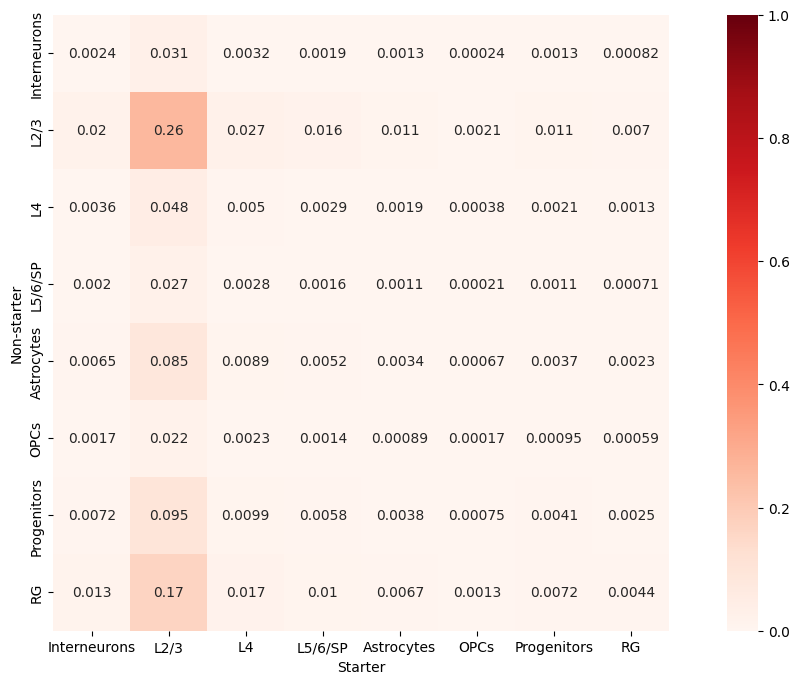

In [62]:
null_df.loc[null_df['non_starter_cell_type'] == 'In', 'non_starter_cell_type'] = 'Interneurons'
null_df.loc[null_df['starter_cell_type'] == 'In', 'starter_cell_type'] = 'Interneurons'

pivot = null_df.pivot(index='non_starter_cell_type', columns='starter_cell_type')['proportion of connections']

pivot = pivot.reindex(["Interneurons","L2/3", "L4", "L5/6/SP", "Astrocytes", "OPCs","Progenitors","RG"], level=0) \
.T.reindex(["Interneurons","L2/3", "L4", "L5/6/SP", "Astrocytes", "OPCs","Progenitors","RG"]).T

plt.figure(figsize=(15,8))

sns.heatmap(pivot, annot=True, cmap = 'Reds', square = True, vmin = 0, vmax = 1)

plt.ylabel('Non-starter')
plt.xlabel('Starter')

## Calculating the observed matrix


<Axes: xlabel='starter cell_type', ylabel='non-starter cell_type'>

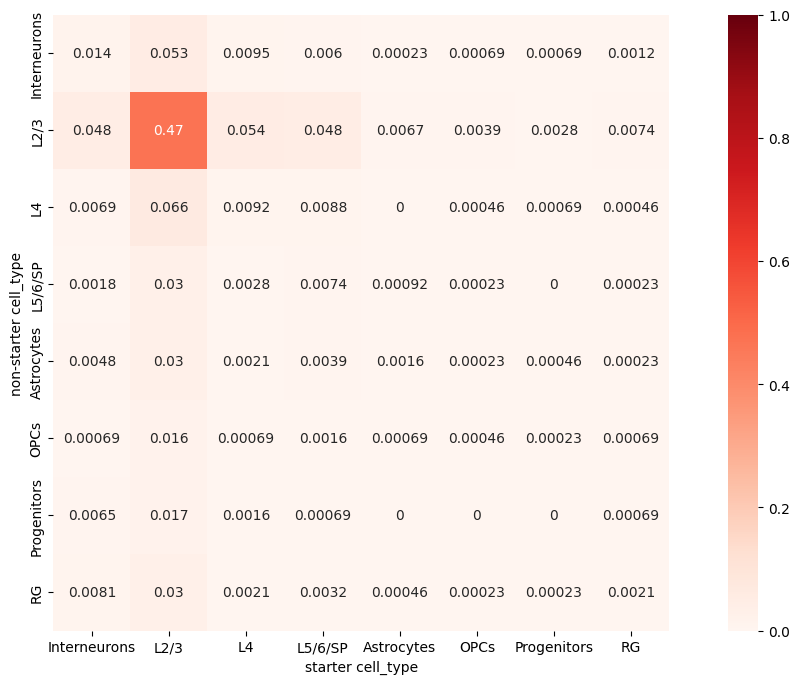

In [63]:
# make sure to run directed network algorithm above before running this code
conn_1 = conn_1_compiling

conn_matrix_df = conn_1_compiling.groupby(['non-starter cell_type','starter cell_type']).count()[['conn_type']].reset_index()
conn_matrix_df.rename(columns = {'conn_type':'observed connections'}, inplace = True)
conn_matrix_df['pre-post'] = conn_matrix_df['non-starter cell_type'] + '-' + conn_matrix_df['starter cell_type']

missing_connections = list((set(null_df['pre-post'])).difference(set(conn_matrix_df['pre-post'])))

df_new = pd.DataFrame({
    'pre-post':missing_connections,
    'observed connections':[0]*len(missing_connections),
    'non-starter cell_type': [x.split('-')[0] for x in missing_connections],
    'starter cell_type': [x.split('-')[1] for x in missing_connections],
})
conn_matrix_df = pd.concat([conn_matrix_df,df_new])

conn_matrix_df['proportion of connections'] = conn_matrix_df['observed connections'] / conn_matrix_df['observed connections'].sum()

plt.figure(figsize=(15,8))

pivot = conn_matrix_df.pivot(index='non-starter cell_type', columns='starter cell_type')['proportion of connections']

pivot = pivot.reindex(["Interneurons","L2/3", "L4", "L5/6/SP", "Astrocytes", "OPCs","Progenitors","RG"], level=0) \
.T.reindex(["Interneurons","L2/3", "L4", "L5/6/SP", "Astrocytes", "OPCs","Progenitors","RG"]).T

sns.heatmap(pivot, annot=True, cmap = 'Reds', square = True, vmin = 0, vmax = 1)

## Calculating the connectivity matrix with enrichment scores

Text(0.5, 58.7222222222222, 'Starter')

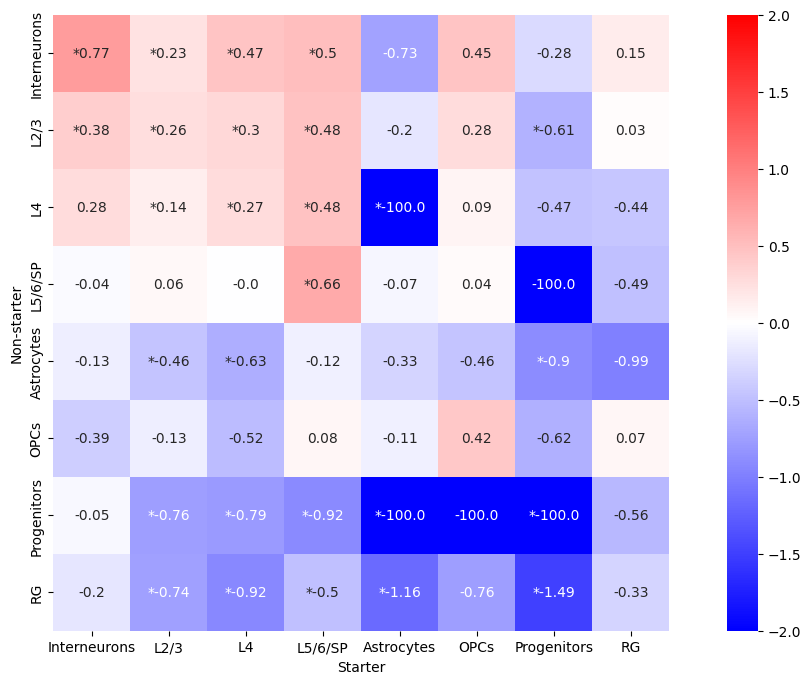

In [64]:
# make sure to have run graph algorithm above
conn_1 = conn_1_compiling

conn_matrix_df = conn_1_compiling.groupby(['non-starter cell_type','starter cell_type']).count()[['conn_type']].reset_index()
conn_matrix_df.rename(columns = {'conn_type':'observed connections'}, inplace = True)
conn_matrix_df['pre-post'] = conn_matrix_df['non-starter cell_type'] + '-' + conn_matrix_df['starter cell_type']

missing_connections = list((set(null_df['pre-post'])).difference(set(conn_matrix_df['pre-post'])))

df_new = pd.DataFrame({
    'pre-post':missing_connections,
    'observed connections':[0]*len(missing_connections),
    'non-starter cell_type': [x.split('-')[0] for x in missing_connections],
    'starter cell_type': [x.split('-')[1] for x in missing_connections],
})
conn_matrix_df = pd.concat([conn_matrix_df,df_new])

conn_matrix_df['proportion of connections'] = conn_matrix_df['observed connections'] / conn_matrix_df['observed connections'].sum()
conn_matrix_df['null proportion of connections'] = conn_matrix_df['pre-post'].apply(lambda x: null_dict[x])

conn_matrix_df['ratio of proportion of connections/null'] = (conn_matrix_df['proportion of connections'] / conn_matrix_df['null proportion of connections']).apply(lambda x: math.log10(x) if x>0 else math.log10(10**-100))

num_observed_connections = conn_matrix_df['observed connections'].sum()

conn_matrix_df['variance of null proportion of connections'] = conn_matrix_df['null proportion of connections'].apply(lambda x: (x*(1-x))/num_observed_connections)
conn_matrix_df['standard error of null proportion of connections'] = conn_matrix_df['variance of null proportion of connections'].apply(lambda x:np.sqrt(x))

conn_matrix_df['p_value_binomial'] = conn_matrix_df.apply(lambda x: binomtest(x['observed connections'], num_observed_connections, x['null proportion of connections'], alternative='two-sided').pvalue, axis = 1)

# for bonferroni corrections
num_tests = len(conn_matrix_df)

conn_matrix_df.loc[conn_matrix_df['p_value_binomial'] <.05/num_tests, '*'] = '*'
conn_matrix_df.loc[conn_matrix_df['p_value_binomial'] >=.05/num_tests, '*'] = ''

conn_matrix_df['ratio of proportion of connections/null with *'] = conn_matrix_df['*'] + conn_matrix_df['ratio of proportion of connections/null'].apply(lambda x: str(round(x,2)) if (x) !=np.inf else 'inf')

pivot2 = conn_matrix_df.pivot(index='non-starter cell_type', columns='starter cell_type')['ratio of proportion of connections/null with *']

pivot = conn_matrix_df.pivot(index='non-starter cell_type', columns='starter cell_type')['ratio of proportion of connections/null']

pivot = pivot.reindex(["Interneurons","L2/3", "L4", "L5/6/SP", "Astrocytes", "OPCs","Progenitors","RG"], level=0) \
.T.reindex(["Interneurons","L2/3", "L4", "L5/6/SP", "Astrocytes", "OPCs","Progenitors","RG"]).T

pivot2 = pivot2.reindex(["Interneurons","L2/3", "L4", "L5/6/SP", "Astrocytes", "OPCs","Progenitors","RG"], level=0) \
.T.reindex(["Interneurons","L2/3", "L4", "L5/6/SP", "Astrocytes", "OPCs","Progenitors","RG"]).T

plt.figure(figsize=(15,8))

# if using log 10 transform
sns.heatmap(pivot,  annot=pivot2, fmt = '', cmap = 'bwr', square = True, vmin=-2, vmax = 2)

plt.ylabel('Non-starter')
plt.xlabel('Starter')

# plt.savefig(fr'C:\Users\antho\Desktop\pub figures\'connectivity matrix with results from binomial tests (pre = uninfected cells; post = infected cells from no-G + infected starters from G).pdf', bbox_inches = 'tight', format = 'pdf')

## Comparing observed proportions to those expected by binomial distribution

Interneurons-Interneurons
Interneurons-L2/3
Interneurons-L4
Interneurons-L5/6/SP
Interneurons-Astrocytes
Interneurons-OPCs
Interneurons-Progenitors
Interneurons-RG
L2/3-Interneurons
L2/3-L2/3
L2/3-L4
L2/3-L5/6/SP
L2/3-Astrocytes
L2/3-OPCs
L2/3-Progenitors
L2/3-RG
L4-Interneurons
L4-L2/3
L4-L4
L4-L5/6/SP
L4-Astrocytes
L4-OPCs
L4-Progenitors
L4-RG
L5/6/SP-Interneurons
L5/6/SP-L2/3
L5/6/SP-L4
L5/6/SP-L5/6/SP
L5/6/SP-Astrocytes
L5/6/SP-OPCs
L5/6/SP-Progenitors
L5/6/SP-RG
Astrocytes-Interneurons
Astrocytes-L2/3
Astrocytes-L4
Astrocytes-L5/6/SP
Astrocytes-Astrocytes
Astrocytes-OPCs
Astrocytes-Progenitors
Astrocytes-RG
OPCs-Interneurons
OPCs-L2/3
OPCs-L4
OPCs-L5/6/SP
OPCs-Astrocytes
OPCs-OPCs
OPCs-Progenitors
OPCs-RG
Progenitors-Interneurons
Progenitors-L2/3
Progenitors-L4
Progenitors-L5/6/SP
Progenitors-Astrocytes
Progenitors-OPCs
Progenitors-Progenitors
Progenitors-RG
RG-Interneurons
RG-L2/3
RG-L4
RG-L5/6/SP
RG-Astrocytes
RG-OPCs
RG-Progenitors
RG-RG


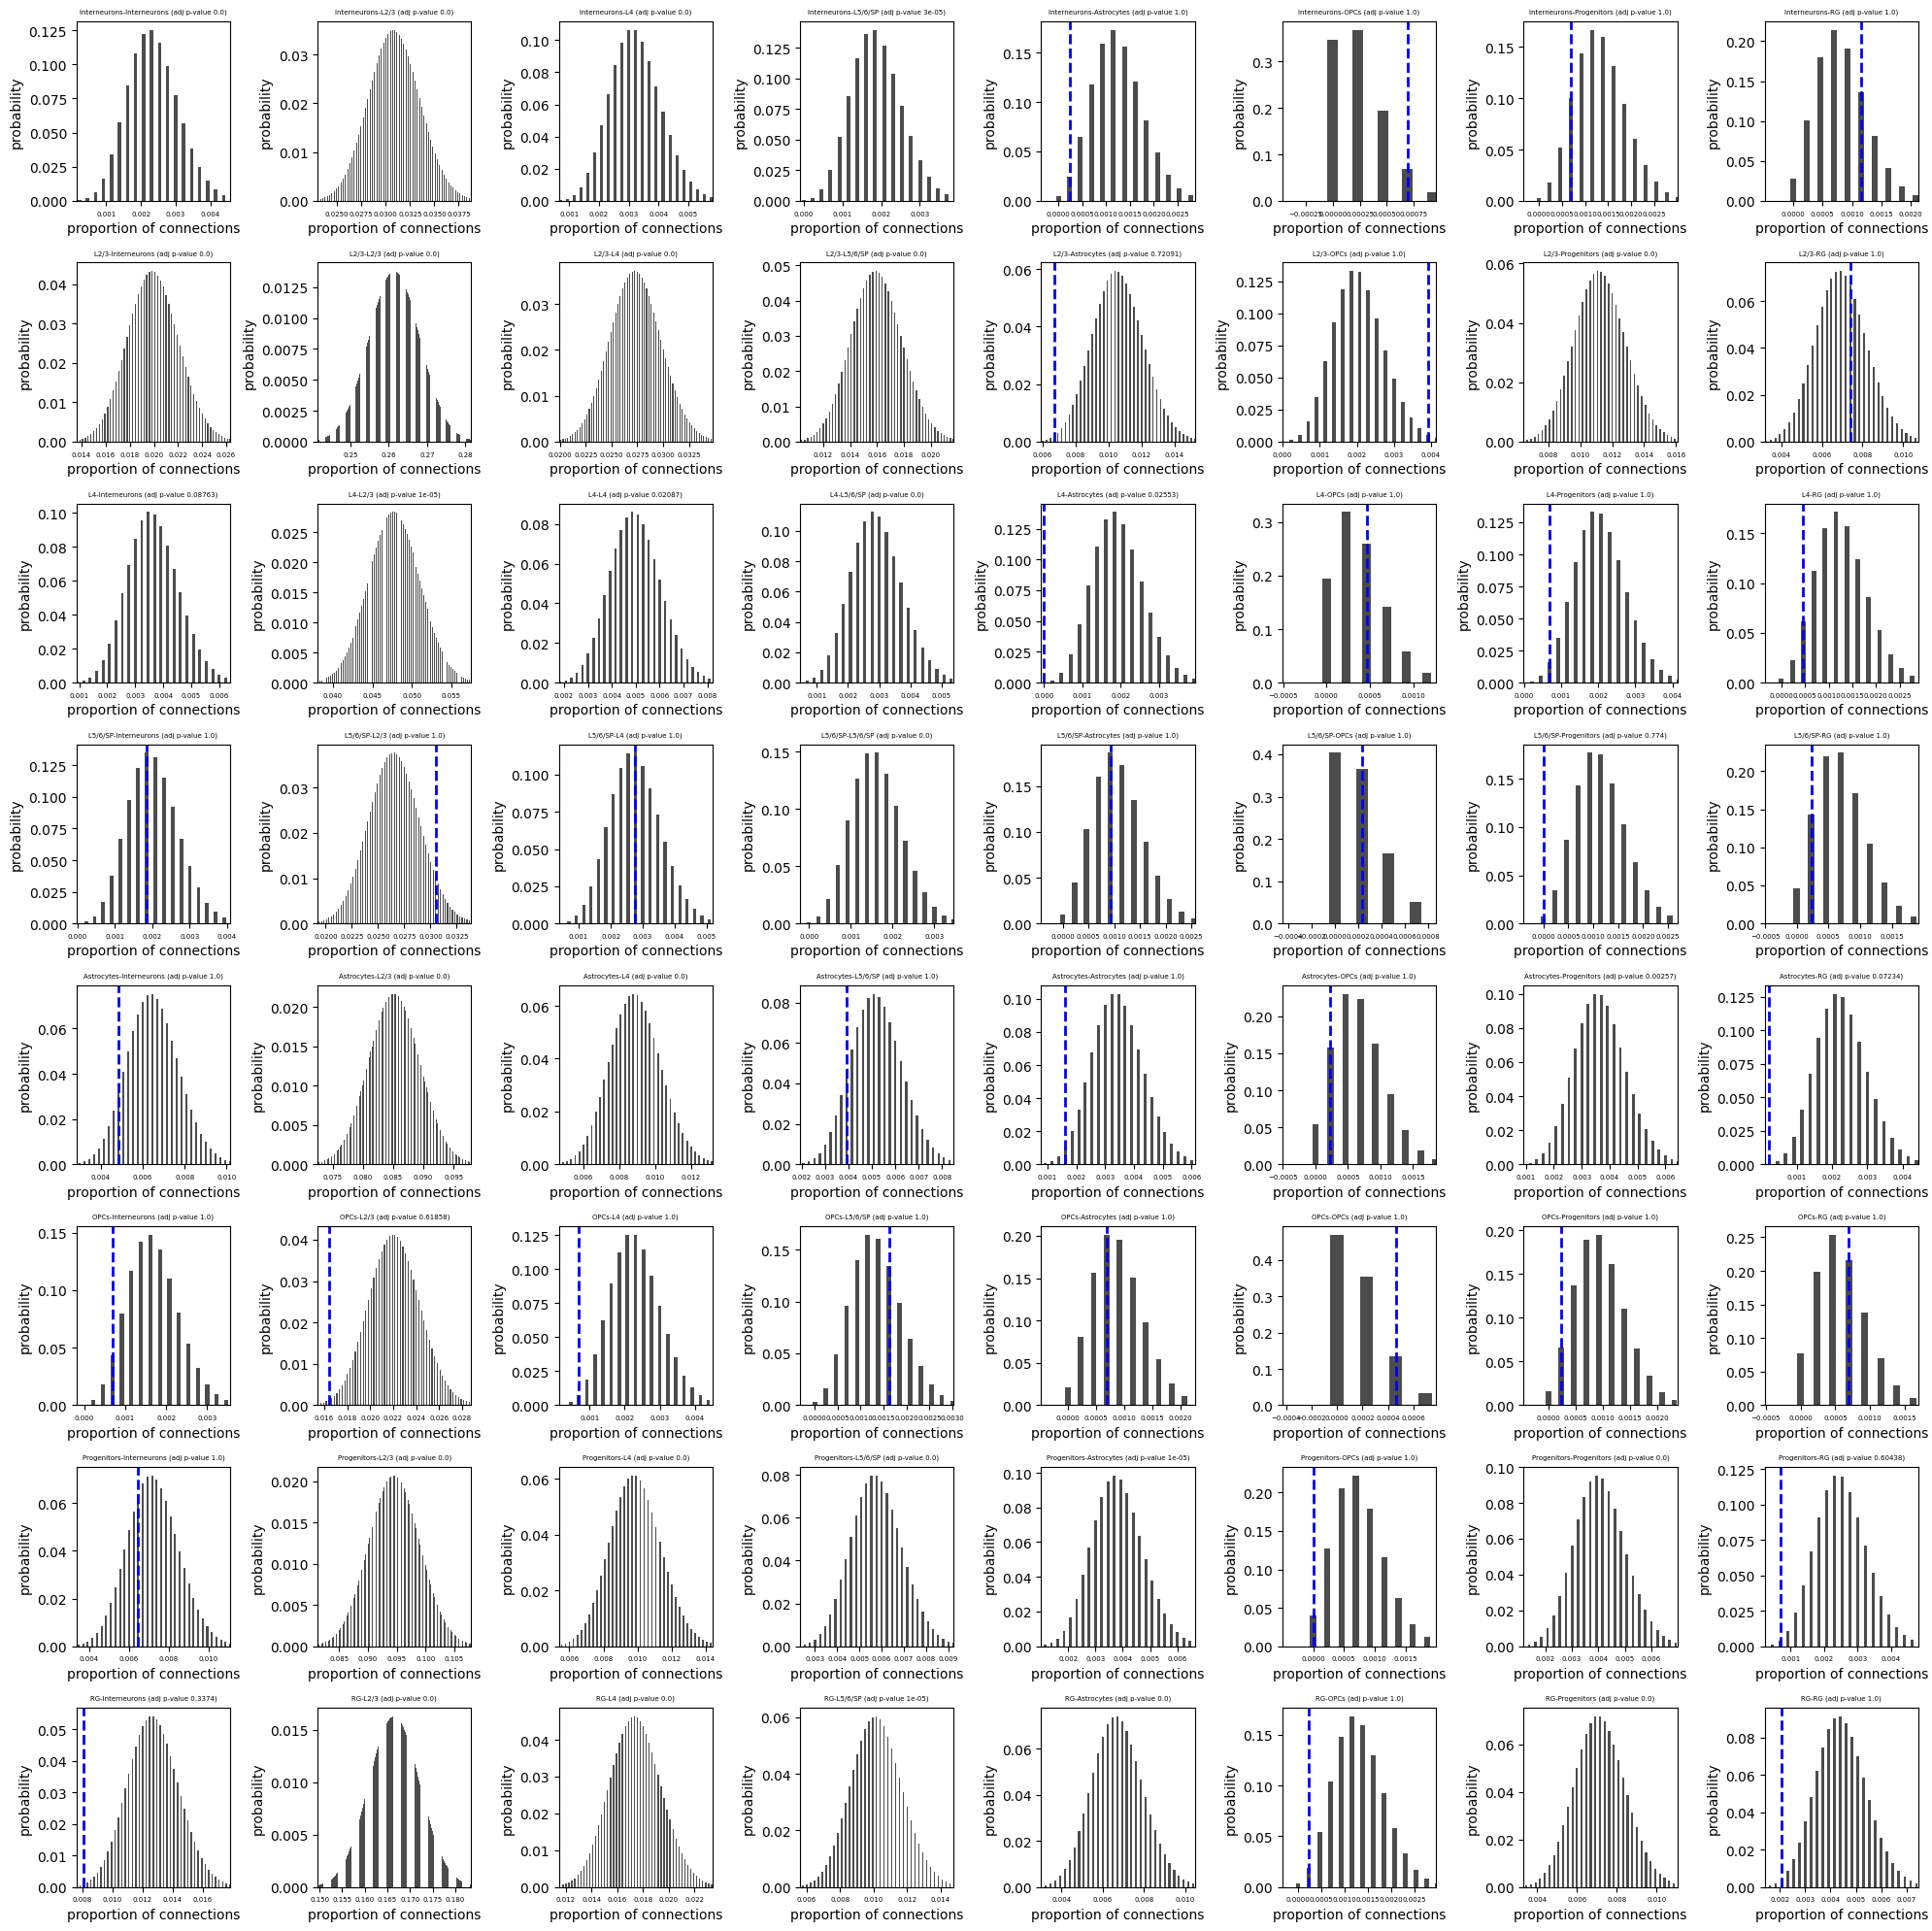

In [66]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))  # can adjust size as needed

conn_matrix_df['adj p-value'] = conn_matrix_df['p_value_binomial']*64
conn_matrix_df.loc[conn_matrix_df['adj p-value'] >= 1, 'adj p-value'] = 1.0 

# for easier iteration, flatten the axes array
axes = axes.flatten()

i=0

celltypes_list = ["Interneurons","L2/3", "L4", "L5/6/SP", "Astrocytes", "OPCs","Progenitors","RG"]
order = [f'{a}-{b}' for a in celltypes_list for b in celltypes_list]

for prepost in order:
    print(prepost)
    reference_df = conn_matrix_df.loc[conn_matrix_df['pre-post'] == prepost]

    # Plot each dataset in the corresponding subplot
    ax = axes[i]
    ax.set_title(f'{prepost} (adj p-value {round(reference_df.iloc[0]['adj p-value'],5)})',  fontsize=5)

    n = 4331
    x = np.arange(0, n+1)
    p = reference_df.iloc[0]['null proportion of connections']
    
    # Calculate the binomial probability mass function
    pmf = binom.pmf(x, n, p)
    
    # Plotting the null distribution of proportions of connections for each conn_type
    ax.bar(x/n, pmf, color='black', width = .0001, alpha=0.7)
        
    # plot line at observed value
    observed_value = reference_df.iloc[0]['proportion of connections']
    ax.axvline(x=observed_value, color='blue', linestyle='--', linewidth=2)
    
    x_max = ax.get_xlim()[1]
    y_max = ax.get_ylim()[1]

    xticks = ax.get_xticks()

    # Set tick labels with desired font size
    ax.tick_params(axis='x', labelsize=5)

    num_stdv = 3
    width = reference_df.iloc[0]['standard error of null proportion of connections']*num_stdv
    ax.set_xlim(p-width,p+width)
    ax.set_xlabel('proportion of connections')
    ax.set_ylabel('probability')
    i+=1
    
# Adjust layout to prevent overlap
plt.tight_layout()
# fig.savefig(fr'C:\Users\antho\Desktop\{num_stdv} stdv - binomial distribution grid - (pre = infected cells from no-G + infected starters from G; post = infected cells from no-G + infected starters from G).pdf', bbox_inches = 'tight', format = 'pdf')

In [ ]:
fig.savefig(fr'C:\Users\antho\Desktop\pub figures\'{num_stdv} stdv - binomial distribution grid - (pre = uninfected cells; post = infected cells from no-G + infected starters from G).pdf', bbox_inches = 'tight', format = 'pdf')

# Shannon entropy calculations

## Functions

In [78]:
# learned how to create df from nested dictionary from https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary
def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict):
    flat_dict = flatten_dict(values_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index)
    df = df.unstack(level=-1)
    df.columns = df.columns.map("{0[1]}".format)
    return df

In [77]:
# make sure datasets and datasets_names are in the same order
def shannon_entropy_calculator (datasets, dataset_names):
    
    shannon_entropy_dict = {}
    
    for dataset_name in dataset_names:
        shannon_entropy_dict[dataset_name] = {}
    
    for df in datasets:
        UMI_sum = df['UMI_Count'].sum()
        df['probability'] = df['UMI_Count'] / UMI_sum
        
        df['uniform count'] = 1
        df['uniform probability'] = df['uniform count']/UMI_sum

    i = 0
    for df in datasets:
        # print(i)
        # print(dataset_names[i])
        # print(df)
        base = 2 
        pk_non_uni = df['probability'].to_numpy(dtype ='float64')
        
        pk_uni = df['uniform probability'].to_numpy(dtype ='float32')
        
        H_non_uni = entropy(pk_non_uni, base=base)
        
        H_uni = entropy(pk_uni, base=base)
    
        shannon_entropy_dict[dataset_names[i]]['observed entropy (bits)'] = H_non_uni
        
        shannon_entropy_dict[dataset_names[i]]['entropy (bits) if library was uniform'] = H_uni
        i += 1
        
    return nested_dict_to_df(shannon_entropy_dict).reset_index().rename(columns = {'index':'dataset'})

## Calculating Shannon entropy for barcode libraries

### import barcode libraries

In [70]:
chen = pd.read_csv(r'C:\Users\antho\Desktop\barcode libraries for paper\published_datasets\chen.csv')
saunders = pd.read_csv(r'C:\Users\antho\Desktop\barcode libraries for paper\published_datasets\saunders.csv')
# saunders.rename(columns = {'Unnamed: 0':'barcode'}, inplace = True)

clark = pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\published_datasets\clark.tsv')
enva = pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\replicates\enva.tsv')
enva = enva.loc[~(enva['barcode'] == 'SO:queryname_SO:queryname_SO:queryname')]
enva = enva.groupby(['CBC','barcode']).sum().reset_index()

envb = pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\replicates\envb.tsv')
hekgt_enva =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\july_2024\viral_diversity_7.30.24\hekgt\enva\completecounts.tsv')

In [71]:
cm_15 =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\2020-2023_plate_size-selected\15_completecounts.tsv')
well_384 =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\2020-2023_plate_size-selected\384_completecounts.tsv')

cm_15 = cm_15.loc[~(cm_15['barcode'] == 'SO:queryname_SO:queryname_SO:queryname')]
well_384 = well_384.loc[~(well_384['barcode'] == 'SO:queryname_SO:queryname_SO:queryname')]

In [72]:
lipofectamine3000_old =pd.read_csv(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\old_transfection\liporealcounts.csv')
xtremegenehp =pd.read_csv(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\old_transfection\xtrerealcounts.csv')

for df in [lipofectamine3000_old, xtremegenehp]:
    df = df.loc[~(df['barcode'] == 'SO:queryname_SO:queryname_SO:queryname')]

xtremegenehp=xtremegenehp[~xtremegenehp.barcode.str.contains("Empty")]
lipofectamine3000_old=lipofectamine3000_old[~lipofectamine3000_old.barcode.str.contains("Empty")]

In [73]:
lipofectamine2000_rep2 =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\july_2024\viral_diversity_7.30.24\lipofectamine2000\2\completecounts.tsv')
lipofectamine2000_rep3 =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\july_2024\viral_diversity_7.30.24\lipofectamine2000\3\completecounts.tsv')
lipofectamine2000_rep4 =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\july_2024\viral_diversity_7.30.24\lipofectamine2000\4\completecounts.tsv')
lipofectamine2000_rep6 =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\july_2024\viral_diversity_7.30.24\lipofectamine2000\6\completecounts.tsv')

lipofectamine3000_rep2 =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\july_2024\viral_diversity_7.30.24\lipofectamine3000\2\completecounts.tsv')
lipofectamine3000_rep3 =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\july_2024\viral_diversity_7.30.24\lipofectamine3000\3\completecounts.tsv')
lipofectamine3000_rep4 =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\july_2024\viral_diversity_7.30.24\lipofectamine3000\4\completecounts.tsv')
lipofectamine3000_rep5 =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\july_2024\viral_diversity_7.30.24\lipofectamine3000\5\completecounts.tsv')

for df in [lipofectamine2000_rep2, lipofectamine2000_rep3, lipofectamine2000_rep4, lipofectamine2000_rep6, lipofectamine3000_rep2,lipofectamine3000_rep3,lipofectamine3000_rep4,lipofectamine3000_rep5]:
    df = df.loc[~(df['barcode'] == 'SO:queryname_SO:queryname_SO:queryname')]

In [74]:
cvs_viral =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\cvs_sad_viral\cvs_completecounts.tsv')
sad_viral =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\cvs_sad_viral\sad_completecounts.tsv')

for df in [cvs_viral,sad_viral]:
    df = df.loc[~(df['barcode'] == 'SO:queryname_SO:queryname_SO:queryname')]

sad_viral = sad_viral.groupby(['CBC','barcode']).sum().reset_index()

In [75]:
cvs_plasmid =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\plasmids\cvs_completecounts.tsv')
sadb19_plasmid =pd.read_table(r'C:\Users\antho\Desktop\barcode libraries for paper\diversity\plasmids\plasmid_sadb19_completecounts.tsv')

cvs_plasmid = cvs_plasmid.loc[~(cvs_plasmid['barcode'] == 'SO:queryname_SO:queryname_SO:queryname')]
sadb19_plasmid = sadb19_plasmid.loc[~(sadb19_plasmid['barcode'] == 'SO:queryname_SO:queryname_SO:queryname')]

### Calculate Shannon entropies

In [79]:
datasets = [cvs_plasmid,sadb19_plasmid, cvs_viral,sad_viral,
            lipofectamine2000_rep2, lipofectamine2000_rep3, lipofectamine2000_rep4, lipofectamine2000_rep6, 
            lipofectamine3000_rep2,lipofectamine3000_rep3,lipofectamine3000_rep4,lipofectamine3000_rep5,
           lipofectamine3000_old, xtremegenehp, cm_15, well_384,chen,saunders,clark,enva,envb,hekgt_enva]

dataset_names = ['cvs_plasmid','sadb19_plasmid', 'cvs_viral','sad_viral',
                 'lipofectamine2000_rep2','lipofectamine2000_rep3','lipofectamine2000_rep4','lipofectamine2000_rep6',
                 'lipofectamine3000_rep2','lipofectamine3000_rep3','lipofectamine3000_rep4','lipofectamine3000_rep5',
                 'lipofectamine3000_old','xtremegenehp','cm_15','well_384','chen','saunders','clark','enva','envb','hekgt_enva']

df_shannon = shannon_entropy_calculator(datasets,dataset_names)

In [80]:
df_shannon['percent of maximal entropy'] = 100 * (df_shannon['observed entropy (bits)']) / (df_shannon['entropy (bits) if library was uniform'])
df_shannon

,dataset,entropy (bits) if library was uniform,observed entropy (bits),percent of maximal entropy
0,chen,13.689452,11.153637,81.476138
1,clark,18.399787,10.559668,57.390166
2,cm_15,19.955096,17.759023,88.994923
3,cvs_plasmid,24.832017,24.437118,98.409716
4,cvs_viral,19.320756,17.486359,90.505560
5,enva,20.481399,20.293134,99.080800
6,envb,19.999999,19.838705,99.193532
7,hekgt_enva,21.872916,20.405495,93.291154
8,lipofectamine2000_rep2,21.277023,14.287507,67.149935
9,lipofectamine2000_rep3,20.949924,14.244791,67.994478


In [246]:
df_shannon.to_csv(r'C:\Users\antho\Desktop\shannon_entropy_table.csv')